In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format='svg'

import numpy as np
np.set_printoptions(precision=6, suppress=True)
np.set_printoptions(threshold=np.inf)

import shl_scripts.shl_tools
from shl_scripts.shl_experiments import SHL

import DNN.mnist_loader as data_loader
import DNN.network as network
from shl_scripts.shl_encode import sparse_encode

In [2]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
training_data,validation_data,test_data=data_loader.load_data()
training_image = training_data[0]
training_supervision = training_data[1]
test_image = test_data[0]
test_supervision = test_data[1]

In [4]:
tag ='2017-05-30_MNIST_MP_DEBUGG_'
DEBUG_DOWNSCALE, verbose = 10, 10
tag ='2017-06-01_MNIST_MP_'
DEBUG_DOWNSCALE, verbose = 1, 10

patch_size = (28,28)
n_dictionary = 15**2
l0_sparseness = 15
n_iter = 2**14
eta = 0.01
eta_homeo = 0
alpha_homeo = 0
verbose=0
n_hidden = 30
list_figures=['show_dico']

 ----- learning for the dico of size : 144 -----
 ----- learning for the dico of size : 225 -----
 ----- learning for the dico of size : 324 -----
 ----- learning for the dico of size : 441 -----
 ----- learning for the dico of size : 576 -----
 ----- learning for the dico of size : 729 -----


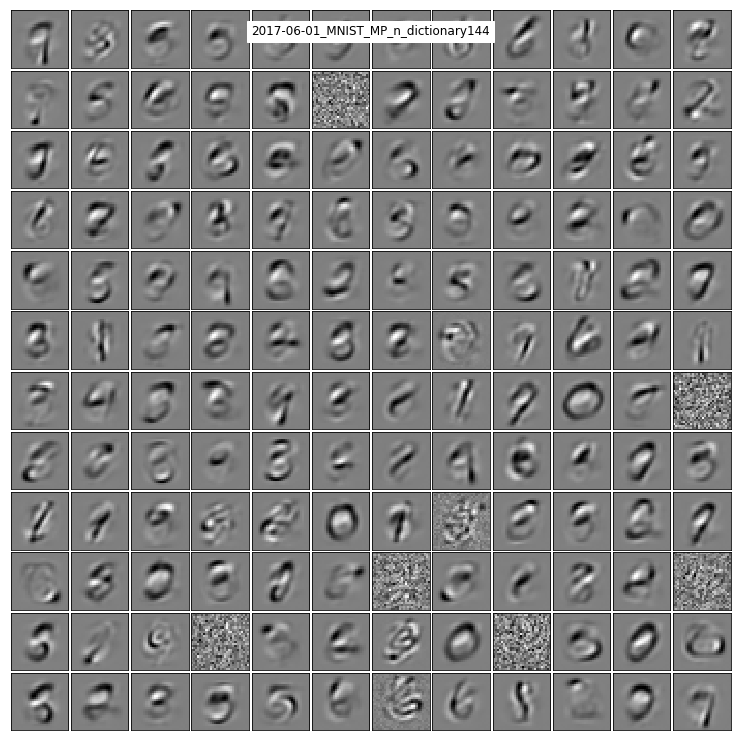

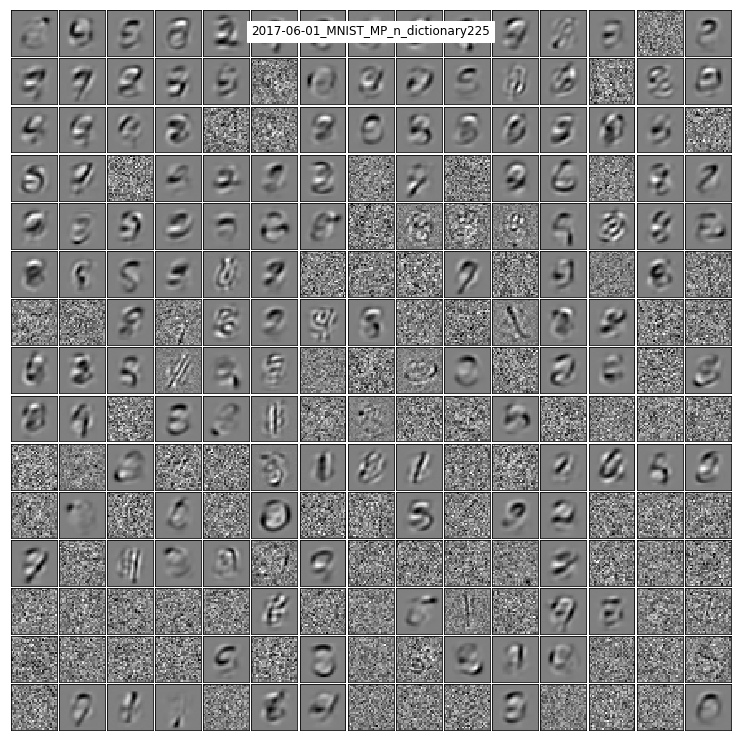

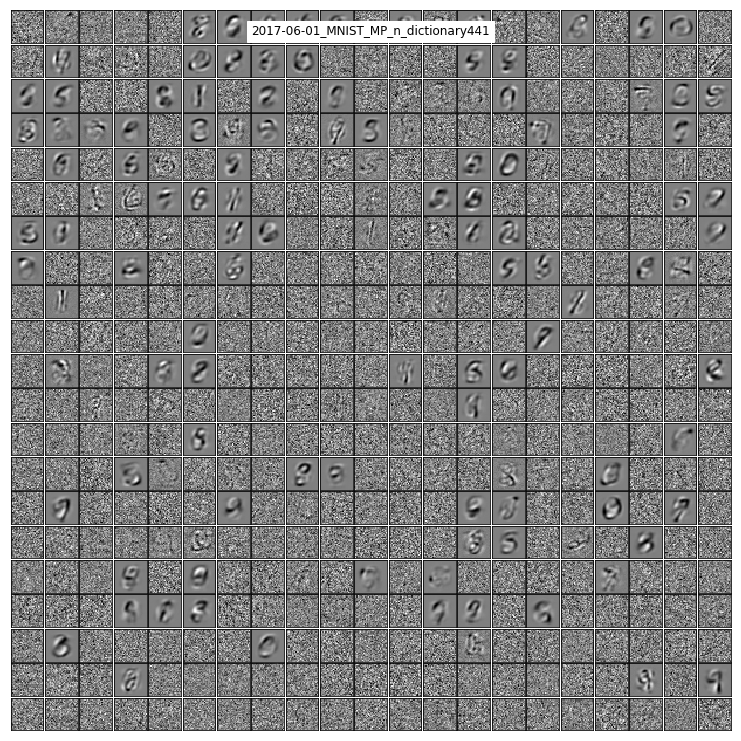

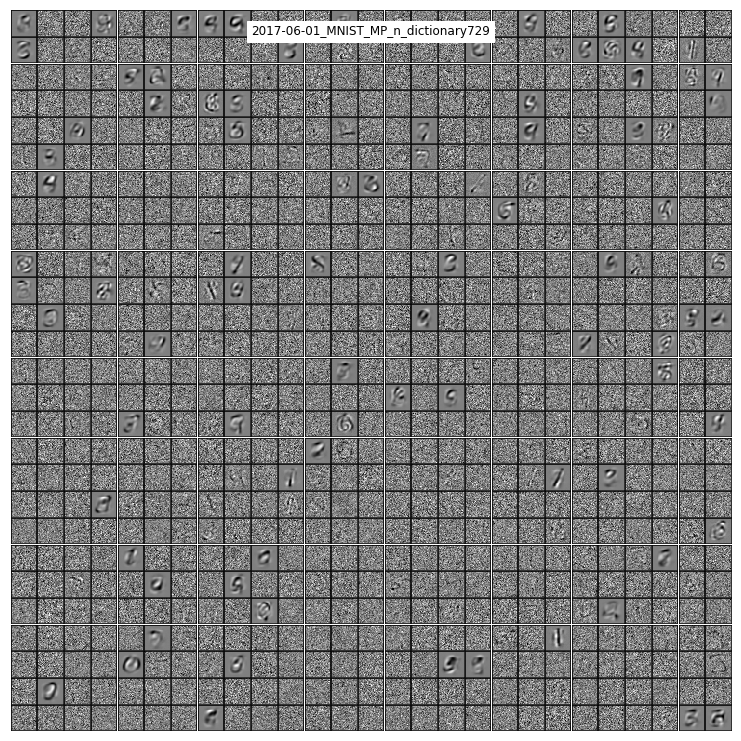

In [5]:
for n_dictionary_ in np.arange(12, 30, 3)**2:
    shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
                eta = eta, eta_homeo = eta_homeo, verbose = verbose, 
                n_iter = n_iter, patch_size = patch_size, l0_sparseness=l0_sparseness, alpha_homeo = alpha_homeo,
                n_dictionary = n_dictionary_) #record_each=1000)
    matname = tag + 'n_dictionary' + str(n_dictionary_)
    dico = shl.learn_dico(data=training_image, matname=matname,list_figures=list_figures)    
    ## formating the date to fit theano standard
    training_sparse_vector = shl.code(data=training_image, dico=dico, matname=matname)
    test_sparse_vector = sparse_encode(test_image, dico.dictionary, algorithm = shl.learning_algorithm,
                                l0_sparseness = shl.l0_sparseness, fit_tol = None,
                                P_cum = dico.P_cum, verbose = 0)
    wrapped_training_data = (training_sparse_vector, training_supervision)
    wrapped_test_data = (test_sparse_vector, test_supervision)
    
    wrapped_inputs = [np.reshape(x, (n_dictionary_, 1)) for x in wrapped_training_data[0]]
    wrapped_results = [vectorized_result(y) for y in wrapped_training_data[1]]
    wrapped_training_data = zip(wrapped_inputs, wrapped_results)
    wrapped_test_inputs = [np.reshape(x, (n_dictionary_, 1)) for x in wrapped_test_data[0]]
    wrapped_test_data_final = zip(wrapped_test_inputs, wrapped_test_data[1])
    
    print(" ----- learning for the dico of size : {0} -----".format(n_dictionary_))
    ## running the network
    net = network.Network([n_dictionary_, n_hidden, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=30,
       mini_batch_size=10,
       eta=3.0,
       test_data=wrapped_test_data_final)

 ----- learning for the dico of sparseness: 15 -----
 ----- learning for the dico of sparseness: 15 -----
 ----- learning for the dico of sparseness: 15 -----
 ----- learning for the dico of sparseness: 15 -----
 ----- learning for the dico of sparseness: 15 -----
 ----- learning for the dico of sparseness: 15 -----
 ----- learning for the dico of sparseness: 15 -----


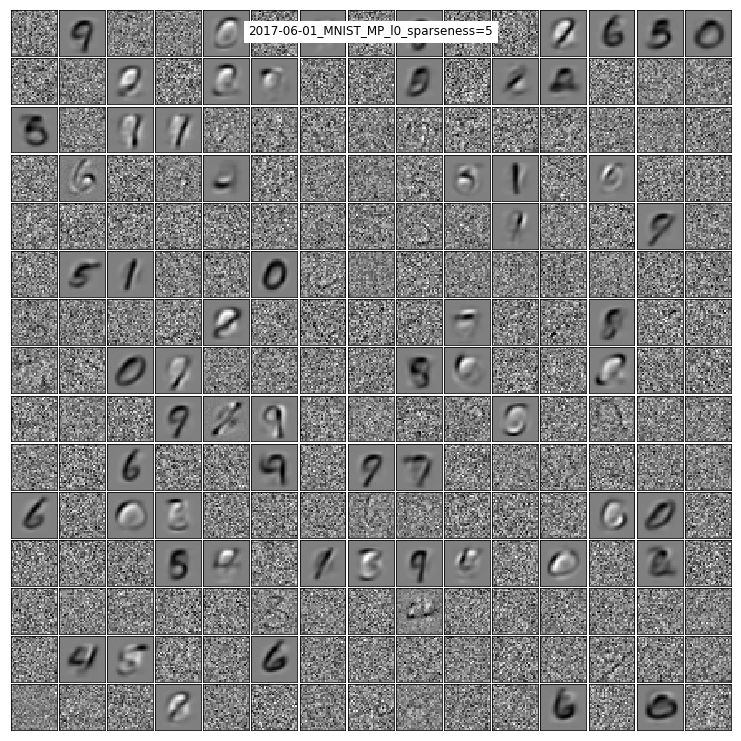

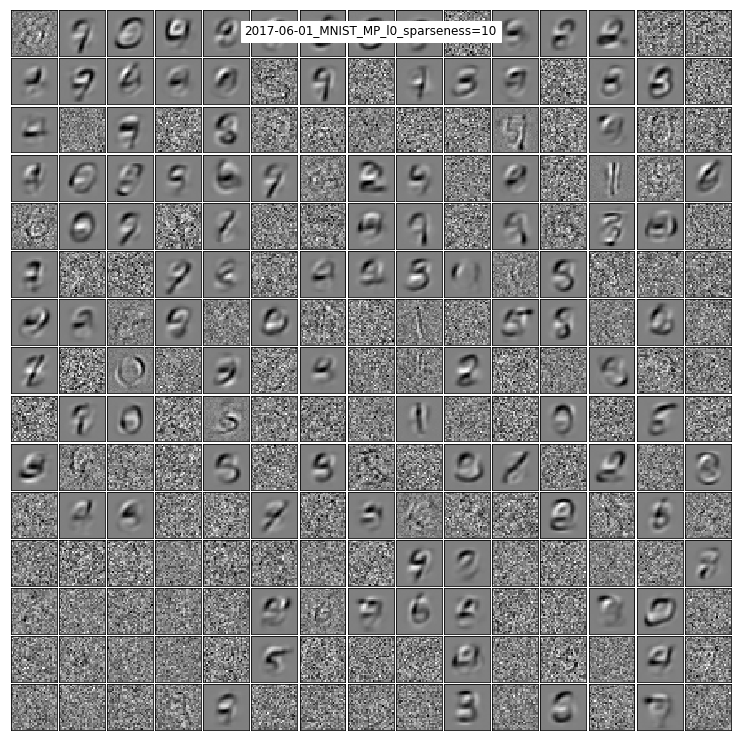

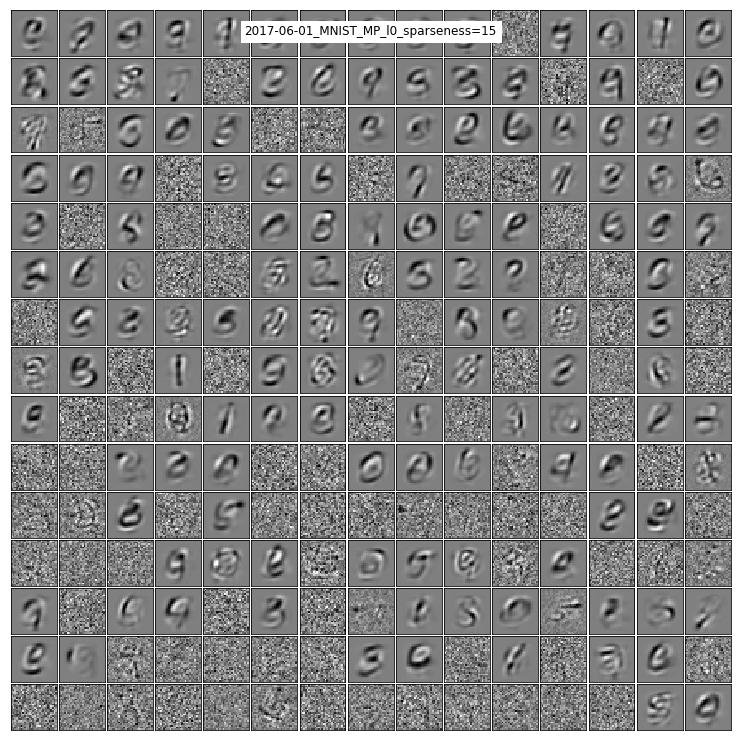

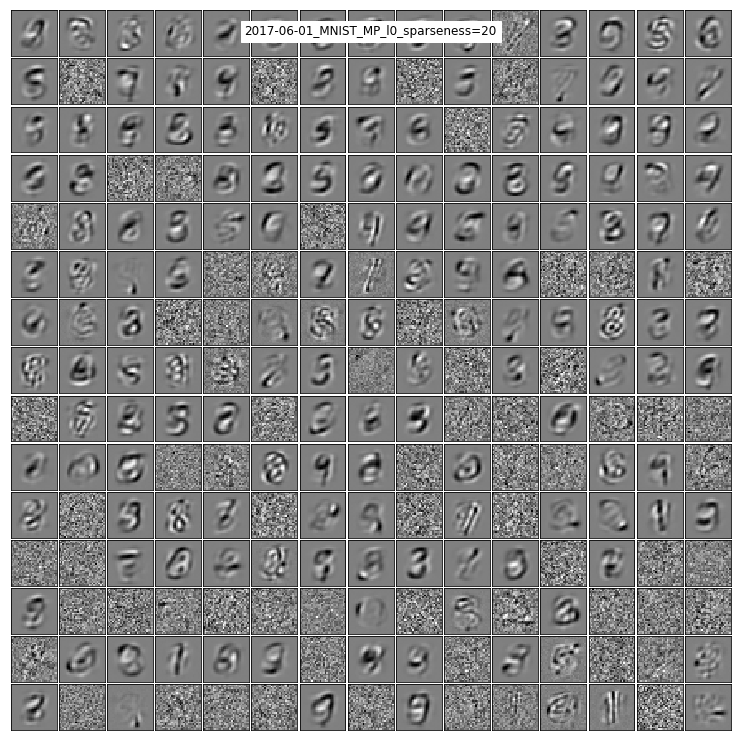

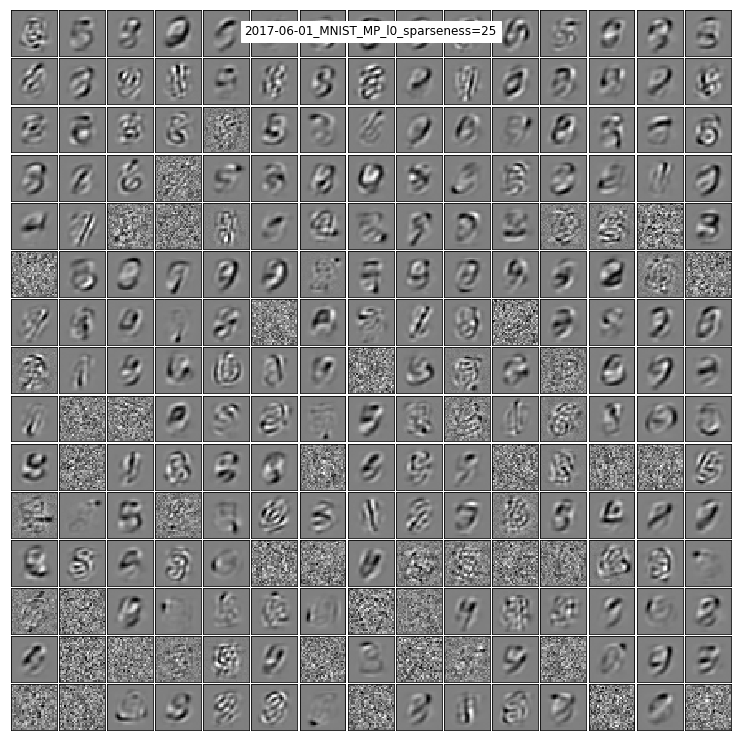

In [6]:
for l0_sparseness_ in np.arange(5, 40, 5):
    shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
                eta = eta, eta_homeo = eta_homeo, verbose=verbose, alpha_homeo = alpha_homeo,
                n_iter = n_iter, patch_size = patch_size, l0_sparseness = l0_sparseness_,
                n_dictionary = n_dictionary)
    matname = tag + 'l0_sparseness=' + str(l0_sparseness_)
    dico = shl.learn_dico(data=training_image,matname=matname, list_figures=list_figures)
    
    ## formating the data to fit theano standard
    training_sparse_vector = shl.code(data=training_image, dico=dico, matname=matname)
    test_sparse_vector = sparse_encode(test_image, dico.dictionary, algorithm = shl.learning_algorithm,
                                l0_sparseness = shl.l0_sparseness, fit_tol = None,
                                P_cum = dico.P_cum, verbose = 0)
    wrapped_training_data = (training_sparse_vector, training_supervision)
    wrapped_test_data = (test_sparse_vector, test_supervision)
    
    wrapped_inputs = [np.reshape(x, (shl.n_dictionary, 1)) for x in wrapped_training_data[0]]
    wrapped_results = [vectorized_result(y) for y in wrapped_training_data[1]]
    wrapped_training_data = zip(wrapped_inputs, wrapped_results)
    wrapped_test_inputs = [np.reshape(x, (shl.n_dictionary, 1)) for x in wrapped_test_data[0]]
    wrapped_test_data_final = zip(wrapped_test_inputs, wrapped_test_data[1])
    
    print(" ----- learning for the dico of sparseness: {0} -----".format(l0_sparseness))
    ## running the network
    net = network.Network([shl.n_dictionary, n_hidden, 10])
    net.SGD(training_data=wrapped_training_data,
       epochs=30,
       mini_batch_size=10,
       eta=3.0,
       test_data=wrapped_test_data_final)